In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
import glob
import anacal
import xlens
import fitsio
import lsst.afw.image as afwImage
import astropy.table as astTable
from astropy.visualization import ZScaleInterval
import fitsio

In [2]:
if False:
    full = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits")
    tract_list = np.unique(full["tract"])
    corr_dir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_noisecorr/"
    for tract_id in tract_list:
        msk = (full["tract"] == tract_id)
        patch_list = full["patch"][msk]
        index_list = full["index"][msk]
        dd = np.zeros((49, 49)) 
        for patch_db, index in zip(patch_list, index_list):
            patch_x = patch_db // 100
            patch_y = patch_db % 100
            patch_id = patch_x + patch_y * 9
            fname = os.path.join(
                corr_dir, 
                f"{tract_id}/{patch_id}/noise_correlation.fits",
            )
            tmp = fitsio.read(fname)
            if not np.any(np.isnan(tmp)):
                dd = dd + tmp
            else:
                print(tract_id, patch_id, index)
        p = dd[24, 24]
        dd = dd / p
        if not np.max(dd) == 1:
            print(tract_id)
        outfname = os.path.join(
            corr_dir, 
            f"{tract_id}.fits",
        )
        fitsio.write(outfname, dd)

In [12]:
full = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits")
tract_list = np.unique(full["tract"])
ii = 0

29


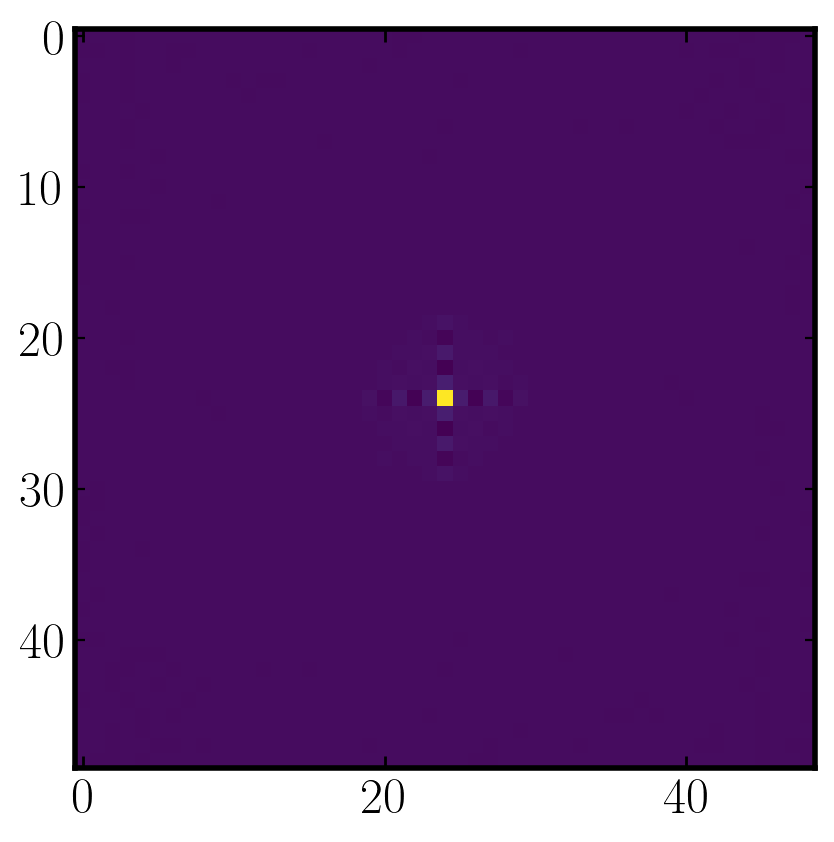

In [42]:
corr_dir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_noisecorr/"
print(ii)
tract_id = tract_list[ii]
fname = os.path.join(
    corr_dir, 
    f"{tract_id}.fits",
)
im = fitsio.read(fname)
plt.close()
plt.imshow(im)
ii += 1

9353 36


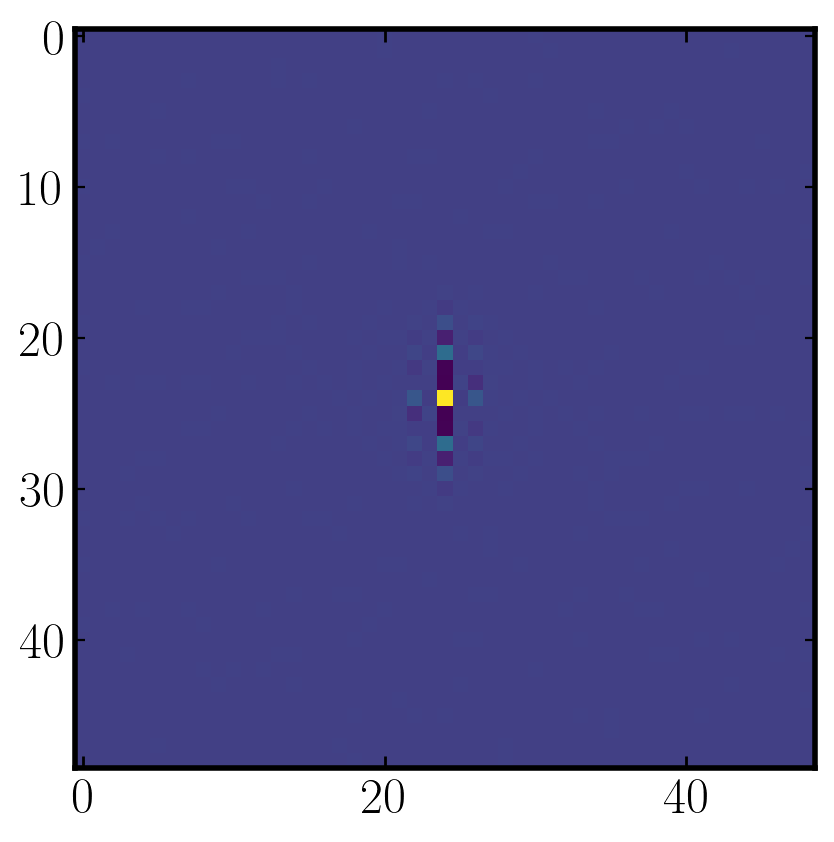

In [252]:
jj = 2
corr_dir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_noisecorr/"
patch_list = full[full['tract']==tract_list[151]]
tract_id = patch_list["tract"][0]
patch_db = patch_list[jj]["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9
print(tract_id, patch_id)
fname = os.path.join(
    corr_dir, 
    str(tract_id),
    str(patch_id),
    "noise_correlation.fits"
)
im = fitsio.read(fname)
plt.close()
plt.imshow(im)

In [139]:
tmp = np.sort(tract_list[id_list])

In [140]:
tmp

array([9353, 9377, 9487, 9494, 9578, 9582, 9585, 9606, 9716, 9736, 9808,
       9810, 9811, 9814, 9815, 9821, 9825], dtype='>i4')

In [141]:
full2 = full[np.isin(full['tract'], tmp)]

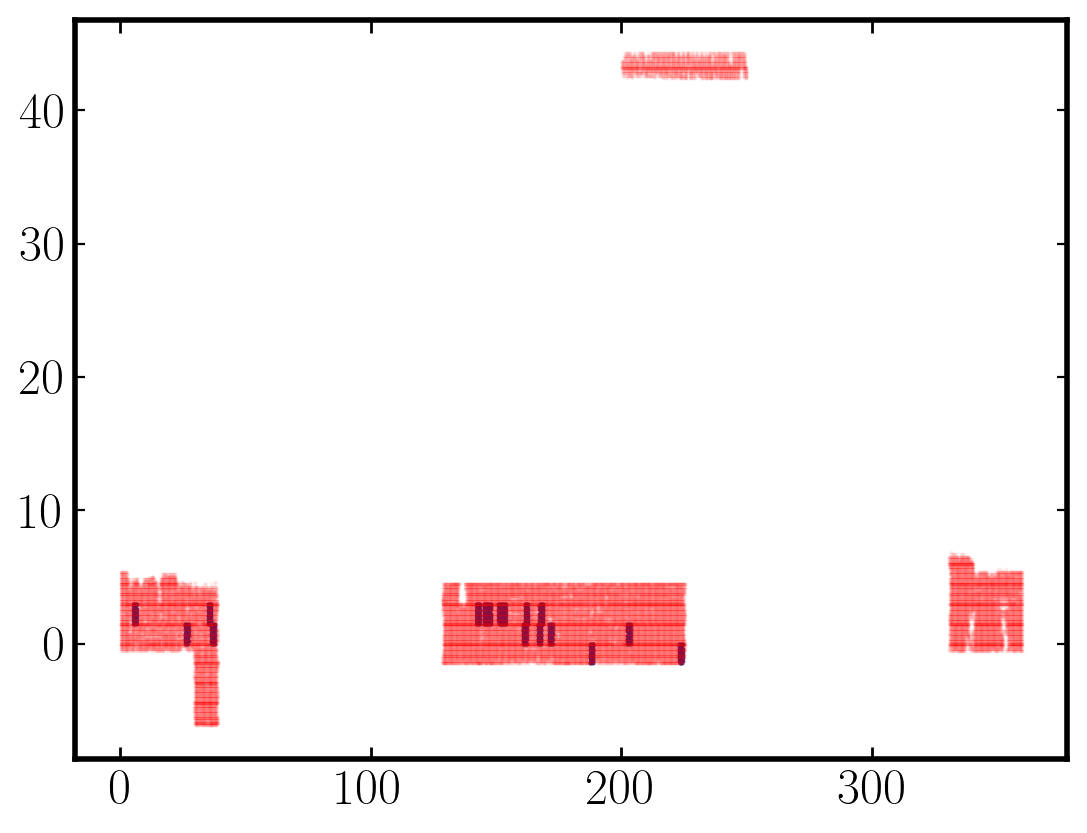

In [143]:
plt.scatter(full2["ra"], full2["dec"], s=0.1)
plt.scatter(full["ra"], full["dec"], s=0.1, color="red", alpha=0.1)

In [166]:
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig
import lsst.afw.image as afwImage
from astropy.visualization import ZScaleInterval
from xlens.process_pipe.anacal_detect import (
    AnacalDetectPipe, AnacalDetectPipeConfig
)

In [253]:
tract_id = 9353
patch_id = 36

# Set up the configuration
config = RingsSkyMapConfig()
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0 / 60  # degrees
config.pixelScale = 0.168  # arcsec/pixel
skymap = RingsSkyMap(config)

config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
task = AnacalDetectPipe(config=config)

def read_files(tract_id, patch_id):
    calexp_dir = f"{os.environ['s23b_calexp']}/{tract_id}/{patch_id}/i"
    exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
    exposure = afwImage.ExposureF.readFits(exp_fname)
    mask_dir = f"{os.environ['s23b_mask']}/{tract_id}/{patch_id}"
    mask_fname = os.path.join(mask_dir, "mask3.fits")
    bmask = fitsio.read(mask_fname)
    nim_dir = f"{os.environ['s23b_nimg']}/{tract_id}/{patch_id}/i"
    nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
    bmask = (bmask | (fitsio.read(nim_fname) <=2).astype(np.int16))
    corr_fname = f"{os.environ['s23b_noisecorr']}/{tract_id}.fits"
    noise_corr = fitsio.read(corr_fname)
    return {
        "exposure": exposure,
        "mask": bmask,
        "noise_corr": noise_corr,
    }


patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()
res = read_files(tract_id, patch_id)

In [254]:
seed = (tract_id * 1000 + patch_id) * 5
out = task.anacal.prepare_data(
    exposure=res["exposure"],
    seed=seed,
    noise_corr=res["noise_corr"],
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
    mask_array=res["mask"],
)
catalog = task.anacal.run(**out)

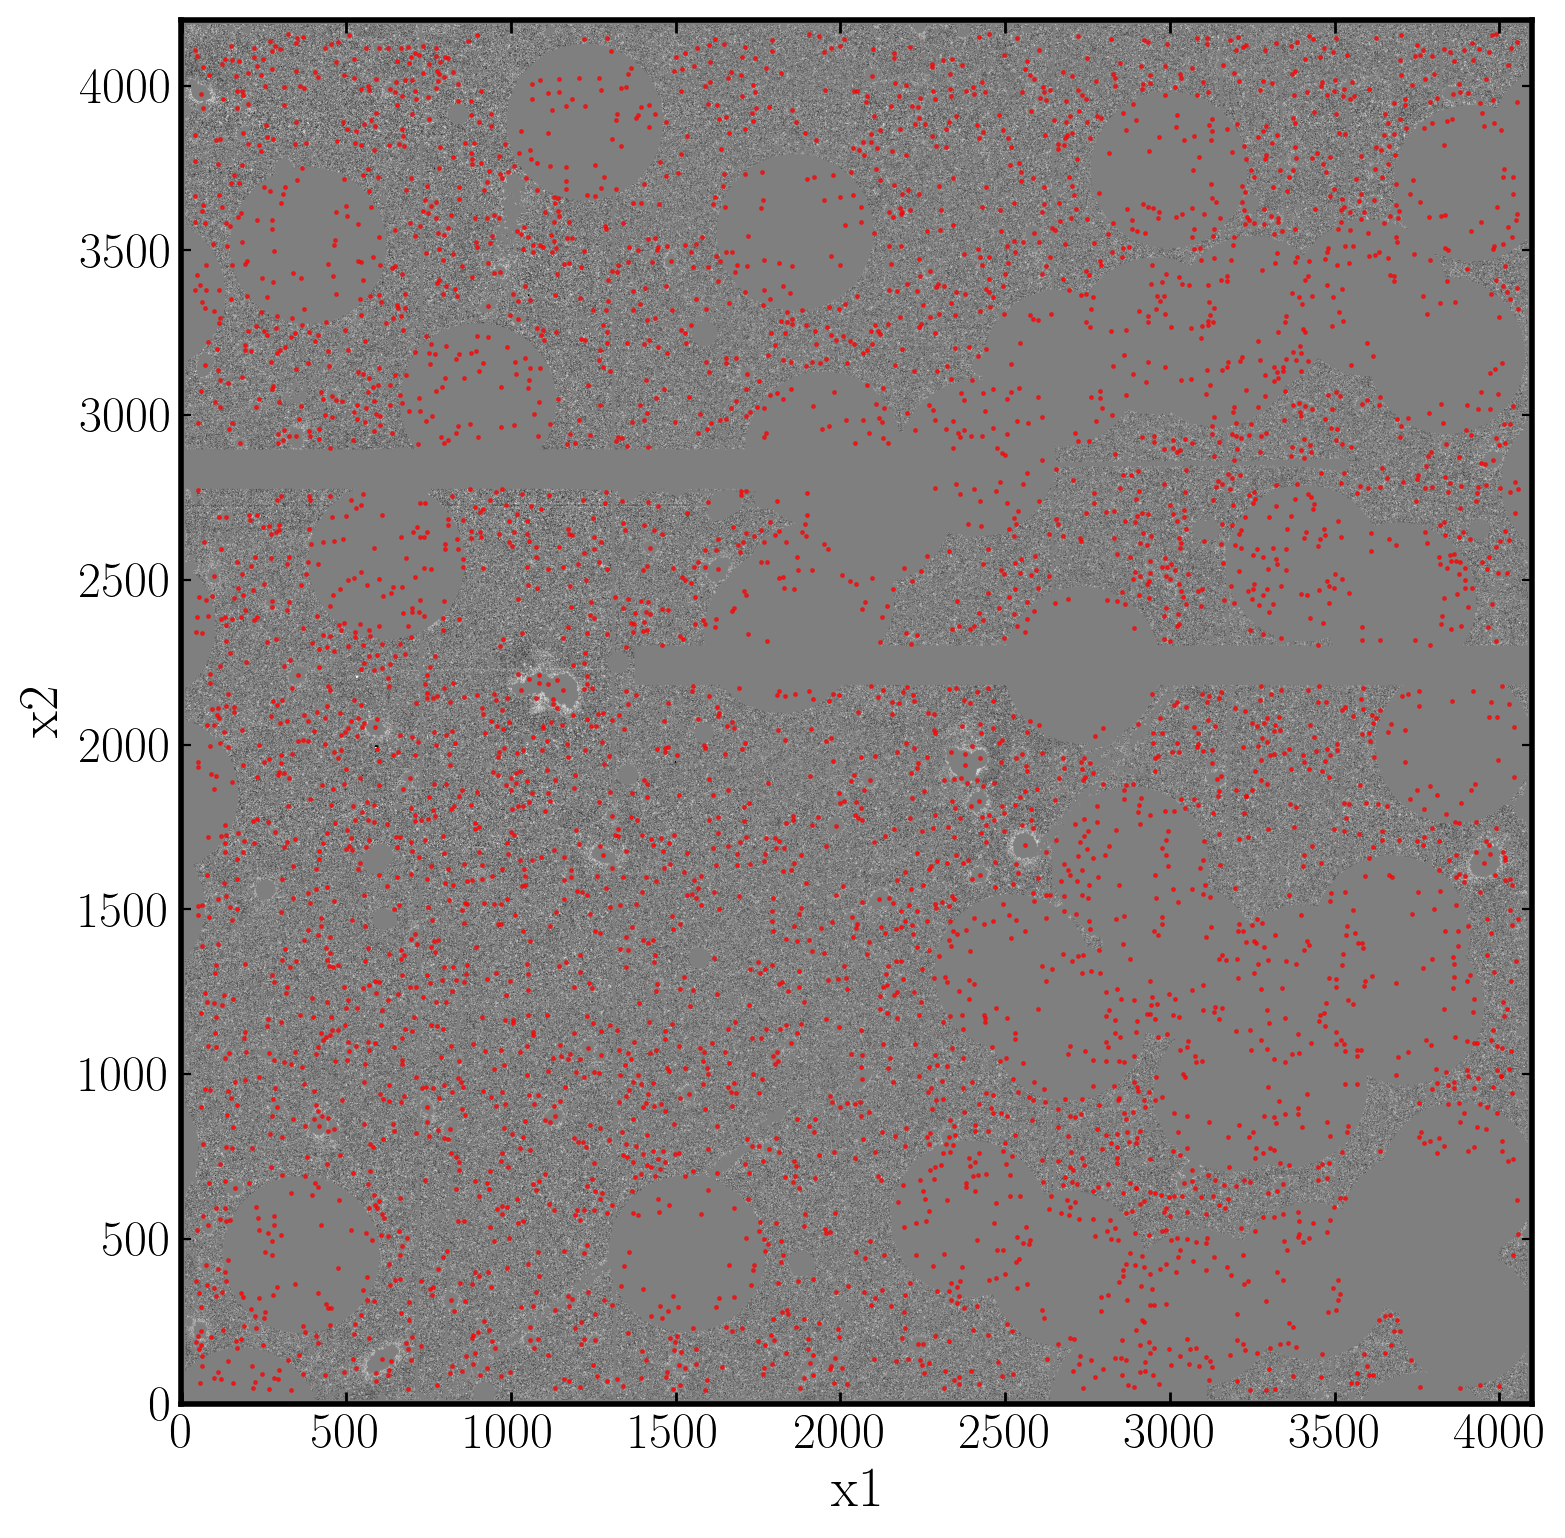

In [255]:
plt.close()
image = out["gal_array"] * (res["exposure"].mask.array == 0).astype(float)
bb = res["exposure"].getBBox()
x1 = catalog["x1"] / 0.168 - bb.beginX
x2 = catalog["x2"] / 0.168 - bb.beginY

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=1.5, c='red', edgecolors='red', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

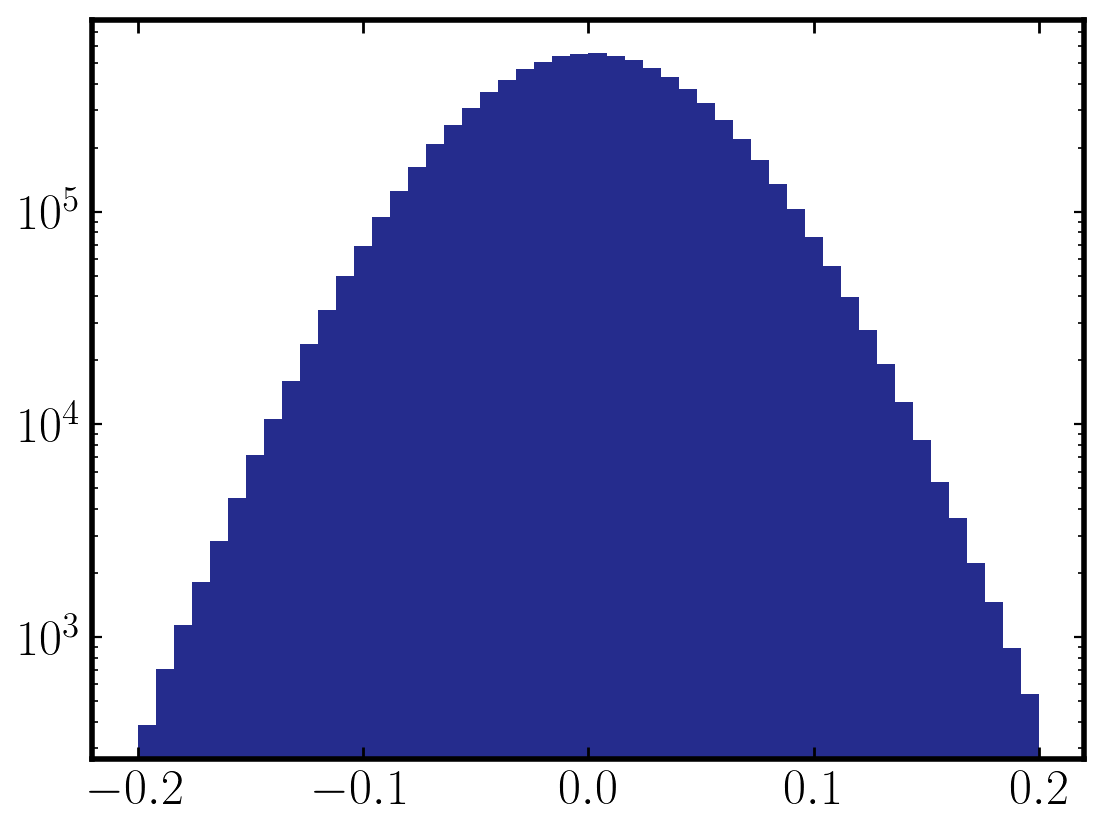

In [256]:
plt.hist(image[image!=0], range=(-0.2, 0.2), bins=50)
plt.yscale("log")

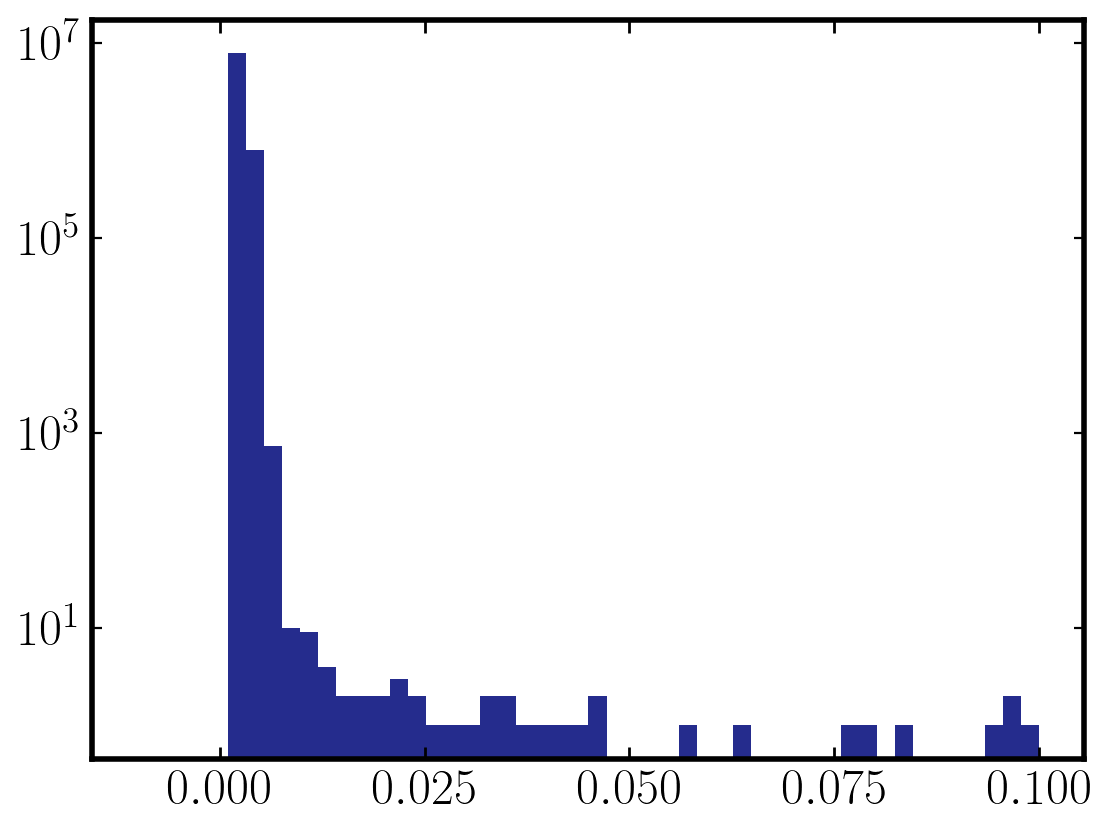

In [257]:
plt.hist(res["exposure"].variance.array[image!=0], range=(-0.01, 0.1), bins=50)
plt.yscale("log")

In [258]:
np.sqrt(np.average(res["exposure"].variance.array))

inf

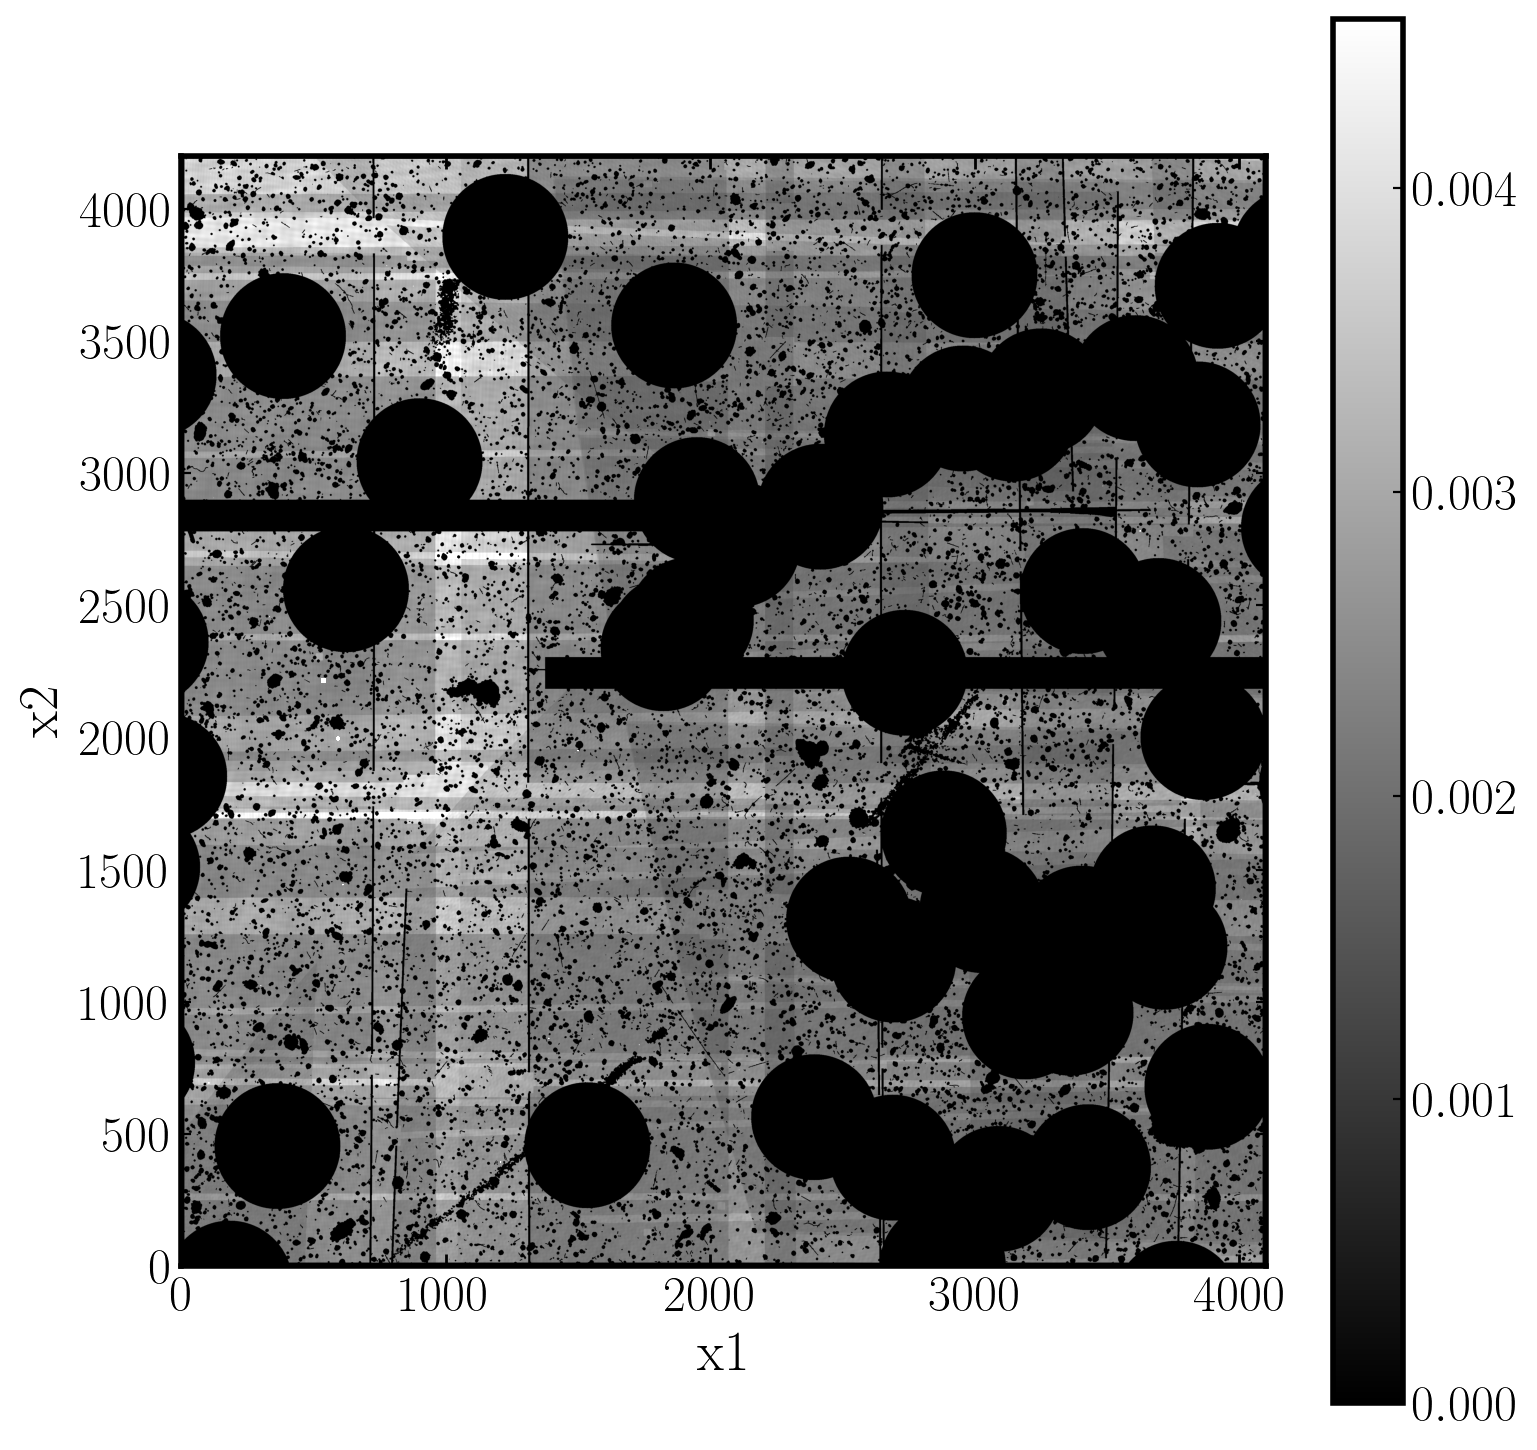

In [259]:
image = res["exposure"].variance.array* (res["exposure"].mask.array == 0)
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.colorbar(im)
plt.show()

In [260]:
exposure = res["exposure"]
noise_array = np.asarray(
    exposure.image.array,
    dtype=np.float32,
)[300:3700, 300:3700]
noise_var = np.nanmedian(exposure.variance.array)
window_array = np.asarray(
    (res["mask"] == 0) & (exposure.mask.array == 0) &
    (exposure.image.array ** 2.0 <  noise_var * 10),
    dtype=np.float32,
)[300:3700, 300:3700]
noise_array[~window_array.astype(bool)] = 0.0
pad_width = ((10, 10), (10, 10))  # ((top, bottom), (left, right))
noise_array = np.pad(
    noise_array,
    pad_width=pad_width,
    mode="constant",
    constant_values=0.0,
)
window_array = np.pad(
    window_array,
    pad_width=pad_width,
    mode="constant",
    constant_values=0.0,
)

npix = 49
ny, nx = window_array.shape
npixl = int(npix // 2)
npixr = int(npix // 2 + 1)
noise_corr = np.fft.fftshift(
    np.fft.ifft2(np.abs(np.fft.fft2(noise_array)) ** 2.0)
).real[
    ny // 2 - npixl : ny // 2 + npixr, nx // 2 - npixl : nx // 2 + npixr
]
window_corr = np.fft.fftshift(
    np.fft.ifft2(np.abs(np.fft.fft2(window_array)) ** 2.0)
).real[
    ny // 2 - npixl : ny // 2 + npixr, nx // 2 - npixl : nx // 2 + npixr
]
del noise_array, window_array
noise_corr = noise_corr / window_corr

In [261]:
noise_var

0.0023369165

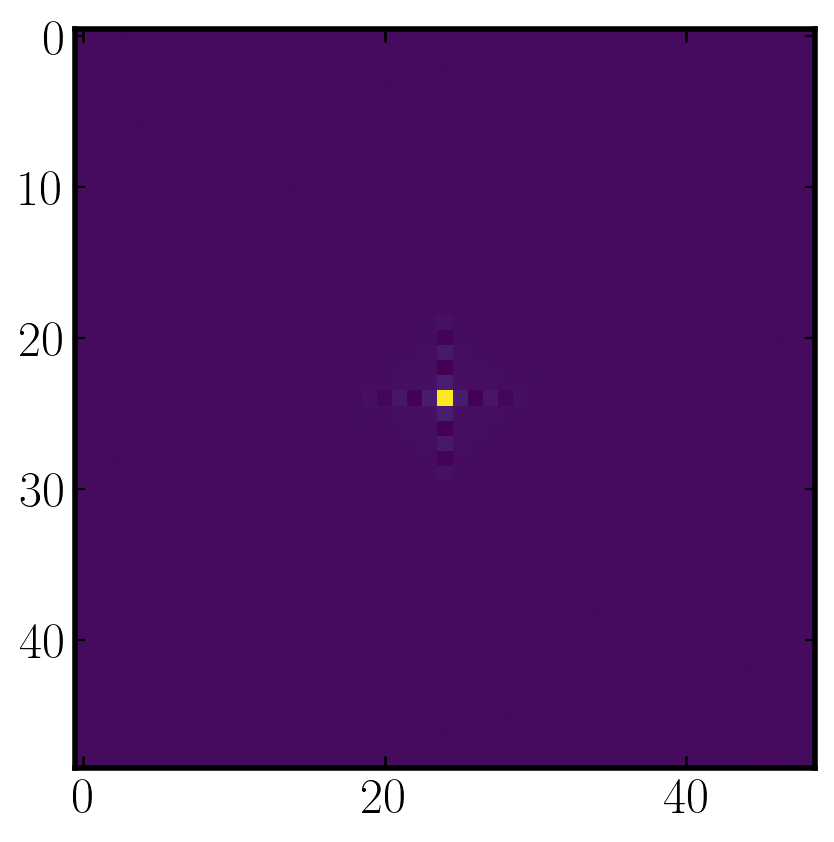

In [262]:
plt.imshow(noise_corr)